In [1]:
import os
import pandas as pd #To allow us to work with dataframes
import numpy as np #To allow us to make mathematical transformations
import matplotlib.mlab as mlab #To create plots
import matplotlib.pylab as plt #To create plots
%matplotlib inline 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4 #width x height in inches
import category_encoders as ce #To encode our nominal and categorical variables
from sklearn import preprocessing, metrics #This module can be helpful when processing data
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, RandomizedSearchCV
from scipy.stats import uniform, chi2_contingency, chisquare
import pickle
import pylab as py
#import scipy as sp #To play with scikit-learn.
import sys 
!{sys.executable} -m pip install xgboost

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#Models to import
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
#from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
#updating xgboost and scipy to get rid of an error (9/18/19)
#RUN IN TERMINAL
# pip install --upgrade xgboost 
# pip install --upgrade scipy
# pip install --upgrade sklearn

#I don't believe that we need this if we export the entire sklearn library. I will comment these out 
#until it's time to start training models.
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

In [3]:
#Open up the pickle file
f = open('DataPipeline2_pt1.pckl','rb')
pickle_list = pickle.load(f)
f.close()

#[0] = combined_df
#[1] = train_y
#[2] = train_IDs
#[3] = test_IDs

#Pull out the important objects in the pickle file
combined_df = pickle_list[0]
train_y = pickle_list[1]
train_IDs = pickle_list[2]
test_IDs = pickle_list[3]

#This is used to double check that I pulled out the correct items.
#combined_df.shape
#len(train_y)
#len(train_IDs)
#len(test_IDs)
#combined_df.columns

In [4]:
###########################################
########### FEATURE ENGINEERING ###########
###########################################
###############ONLY RUN ONCE###############

#Dropping some extra columns off the bat that are redundant
#Drop BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF because TotalBsmtSF covers these.
combined_df = combined_df.drop(['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'],axis=1)
#Drop 1stFlrSF + 2ndFlrSF + LowQualFinSF because GrLivArea covers these.
combined_df = combined_df.drop(['1stFlrSF','2ndFlrSF','LowQualFinSF'],axis=1)

#Need to seperate the training data from the test data just in case I want to look at the SalesPrices and how 
#they relate to the different categories for some of these features.
train_X2 = combined_df.loc[combined_df.Id <= train_IDs[len(train_IDs)-1],:]
#Combine it with train_y
train_X2 = pd.concat([train_X2,train_y],axis=1)
#train_X2.columns

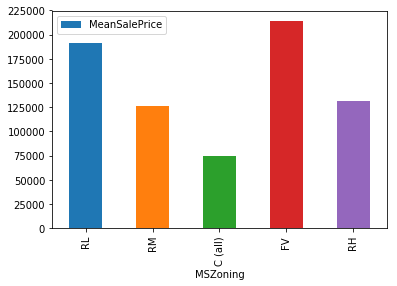

In [5]:
########## MSZoning ############
#Look at total counts from the entire test and train datasets 
# combined_df.MSZoning.value_counts().plot(kind='bar')
# combined_df.MSZoning.value_counts()

#Lets look at SalesPrice 
MSZ_Unique = train_X2.MSZoning.unique()
MSZ_Uvals = pd.DataFrame()
for i in MSZ_Unique:
    #print(i)
    curr_SP = train_X2.loc[train_X2.MSZoning == i,'SalePrice']
    mean_val = np.mean(curr_SP)
    std_val = np.std(curr_SP)
    MSZ_Uvals = MSZ_Uvals.append({'MSZoning':i,'MeanSalePrice':mean_val,'STDSalePrice':std_val},ignore_index=True)

MSZ_Uvals.plot(x='MSZoning',y='MeanSalePrice',kind='bar')
MSZ_Uvals

##Looking at MSZoning = RL
# #train_X2.loc[train_X2.MSZoning == 'RL',:].boxplot(column='SalePrice')
# MSZ_RL = train_X2.loc[train_X2.MSZoning == 'RL','SalePrice']
# MSZ_LQ, MSZ_HQ = MSZ_RL.quantile([0.25,0.75])
# #All SalePrice values above the 3rd quantile
# MSZ_RL.loc[MSZ_RL>MSZ_HQ].hist(bins=40)
# #len(MSZ_RL.loc[MSZ_RL>MSZ_HQ]) #287 values

# #Looking at MSZoning = RH
# train_X2.loc[train_X2.MSZoning == 'RH',:]
# train_X2.loc[train_X2.MSZoning == 'RH','SalePrice']

# #Looking at MSZoning = C (all)
# train_X2.loc[train_X2.MSZoning == 'C (all)',:]
# train_X2.loc[train_X2.MSZoning == 'C (all)','SalePrice']

############# Alley ##############
# combined_df.Alley.value_counts().plot(kind='bar')
# combined_df.Alley.value_counts()

#This column is too uniform so I'm removing this column from the dataset.
combined_df = combined_df.drop('Alley',axis=1)

In [6]:
########### LotShape ############
# combined_df.LotShape.value_counts().plot(kind='bar')
# combined_df.LotShape.value_counts()

LS_Unique = train_X2.LotShape.unique()
LS_vals = pd.DataFrame(columns=['LotShape','MeanSalePrice','STDSalePrice'])
for i in LS_Unique:
    curr_SP = train_X2.loc[train_X2.LotShape == i,'SalePrice']
    curr_mean = np.mean(curr_SP)
    curr_std = np.std(curr_SP)
    LS_vals = LS_vals.append({'LotShape':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)
#LS_vals



# rcParams['figure.figsize'] = 12, 4 #width x height in inches
# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.LotShape=='Reg','SalePrice'],alpha=0.5,label='Reg',bins=40)
# ax.hist(train_X2.loc[train_X2.LotShape=='IR1','SalePrice'],alpha=0.5,label='IR1',bins=35)
# ax.hist(train_X2.loc[train_X2.LotShape=='IR2','SalePrice'],alpha=0.5,label='IR2')
# ax.hist(train_X2.loc[train_X2.LotShape=='IR3','SalePrice'],alpha=1,label='IR3')
# leg = ax.legend()


#Only need to run once, then comment out.
combined_df.loc[combined_df.LotShape=='IR1','LotShape'] = 'IR'
combined_df.loc[combined_df.LotShape=='IR2','LotShape'] = 'IR'
combined_df.loc[combined_df.LotShape=='IR3','LotShape'] = 'IR'



for i in combined_df.index:
    curr_val = combined_df.loc[i,'LotShape']
    if(curr_val == 'Reg'):
        combined_df.loc[i,'LotShapeBinary'] = 1
    else:
        combined_df.loc[i,'LotShapeBinary'] = 0
#Double check that the for loop worked.
combined_df.LotShapeBinary.value_counts()
combined_df.LotShape.value_counts()

#We can drop LotShape now in favor of LotShapeBinary.
combined_df = combined_df.drop('LotShape',axis=1)

In [7]:
########### LandContour ###########
# combined_df.LandContour.value_counts().plot(kind='bar')
# combined_df.LandContour.value_counts()

LC_unique = train_X2.LandContour.unique()
LC_Uvals = pd.DataFrame()

for i in LC_unique:
    curr_SP = train_X2.loc[train_X2.LandContour==i,'SalePrice']
    curr_mean = np.mean(curr_SP)
    curr_std = np.std(curr_SP)
    LC_Uvals = LC_Uvals.append({'LandContour':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)

LC_Uvals


 
# rcParams['figure.figsize'] = 12, 4 #width x height in inches
# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.LandContour=='Lvl','SalePrice'],alpha=0.5,label='Lvl',bins=40)
# ax.hist(train_X2.loc[train_X2.LandContour=='HLS','SalePrice'],alpha=0.5,label='HLS',bins=10)
# ax.hist(train_X2.loc[train_X2.LandContour=='Bnk','SalePrice'],alpha=0.5,label='Bnk',bins=10)
# ax.hist(train_X2.loc[train_X2.LandContour=='Low','SalePrice'],alpha=0.5,label='Low',bins=10)
# leg = ax.legend()

#We will drop this column because most of the values are Lvl, and the rest of the LandContour values have a lot of 
#the same values as Lvl and aren't a good hint of SalePrice.
combined_df = combined_df.drop('LandContour',axis=1)

In [8]:
############ LotConfig ############
# combined_df.LotConfig.value_counts().plot(kind='bar')
# combined_df.LotConfig.value_counts()

LCo_unique = train_X2.LotConfig.unique()
LCo_Uvals = pd.DataFrame()

# for i in LCo_unique:
#     curr_SP = train_X2.loc[train_X2.LotConfig==i,'SalePrice']
#     curr_mean = np.mean(curr_SP)
#     curr_std = np.std(curr_SP)
#     LCo_Uvals = LCo_Uvals.append({'LotConfig':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)

# LCo_Uvals


# rcParams['figure.figsize'] = 12, 4 #width x height in inches
# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.LotConfig=='Inside','SalePrice'],alpha=0.5,label='Inside',bins=80)
# ax.hist(train_X2.loc[train_X2.LotConfig=='Corner','SalePrice'],alpha=0.5,label='Corner',bins=30)
# ax.hist(train_X2.loc[train_X2.LotConfig=='CulDSac','SalePrice'],alpha=0.5,label='CulDSac',bins=10)
# ax.hist(train_X2.loc[train_X2.LotConfig=='FR2','SalePrice'],alpha=0.5,label='FR2',bins=10)
# ax.hist(train_X2.loc[train_X2.LotConfig=='FR3','SalePrice'],alpha=1,label='FR3',bins=3)
# leg = ax.legend()

combined_df.loc[combined_df.LotConfig=='FR2','LotConfig'] = 'FR'
combined_df.loc[combined_df.LotConfig=='FR3','LotConfig'] = 'FR'

In [9]:
########### LandSlope ############
# combined_df.LandSlope.value_counts().plot(kind='bar')
# combined_df.LandSlope.value_counts()

LS_unique = train_X2.LandSlope.unique()
LS_Uvals = pd.DataFrame()

for i in LS_unique:
    curr_SP = train_X2.loc[train_X2.LandSlope==i,'SalePrice']
    curr_mean = np.mean(curr_SP)
    curr_std = np.std(curr_SP)
    LS_Uvals = LS_Uvals.append({'LandSlope':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)

LS_Uvals


# rcParams['figure.figsize'] = 12, 4 #width x height in inches
# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.LandSlope=='Gtl','SalePrice'],alpha=0.5,label='Gtl',bins=60)
# ax.hist(train_X2.loc[train_X2.LandSlope=='Mod','SalePrice'],alpha=0.5,label='Mod',bins=20)
# ax.hist(train_X2.loc[train_X2.LandSlope=='Sev','SalePrice'],alpha=0.5,label='Sev',bins=5)
# leg = ax.legend()


#I'm going to drop the LandSlope variable.
combined_df = combined_df.drop('LandSlope',axis=1)

In [10]:
############ Condition1 ############
# combined_df.Condition1.value_counts().plot(kind='bar')
# combined_df.Condition1.value_counts()

C1_unique = train_X2.Condition1.unique()
C1_Uvals = pd.DataFrame()

for i in C1_unique:
    curr_SP = train_X2.loc[train_X2.Condition1==i,'SalePrice']
    curr_mean = np.mean(curr_SP)
    curr_std = np.std(curr_SP)
    C1_Uvals = C1_Uvals.append({'Condition1':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)
    
#C1_Uvals


# rcParams['figure.figsize'] = 12, 4 #width x height in inches
# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.Condition1=='Norm','SalePrice'],alpha=0.5,label='Norm',bins=80)
# ax.hist(train_X2.loc[train_X2.Condition1=='Feedr','SalePrice'],alpha=0.5,label='Feedr',bins=15)
# ax.hist(train_X2.loc[train_X2.Condition1=='Artery','SalePrice'],alpha=0.5,label='Artery',bins=10)
# ax.hist(train_X2.loc[train_X2.Condition1=='RRAn','SalePrice'],alpha=0.5,label='RRAn',bins=10)
# leg = ax.legend()

combined_df.Condition1.value_counts()

Norm      2508
Feedr      164
Artery      92
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64

In [11]:
############ Condition1 ############
#We had to split the histograms because there was too many values to look at at once.
# rcParams['figure.figsize'] = 12, 4 #width x height in inches
# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.Condition1=='PosN','SalePrice'],alpha=0.5,label='PosN',bins=10)
# ax.hist(train_X2.loc[train_X2.Condition1=='RRAe','SalePrice'],alpha=0.5,label='RRAe',bins=10)
# ax.hist(train_X2.loc[train_X2.Condition1=='PosA','SalePrice'],alpha=0.5,label='PosA',bins=10)
# ax.hist(train_X2.loc[train_X2.Condition1=='RRNn','SalePrice'],alpha=0.5,label='RRNn',bins=10)
# ax.hist(train_X2.loc[train_X2.Condition1=='RRNe','SalePrice'],alpha=1,label='RRNe',bins=5)
# leg = ax.legend()

# combined_df.Condition1.value_counts()


#Will remove Condition1 because its super uniform AND there are alot of categories.
combined_df = combined_df.drop('Condition1',axis=1)

1Fam      2422
TwnhsE     227
Duplex     109
Twnhs       96
2fmCon      62
Name: BldgType, dtype: int64

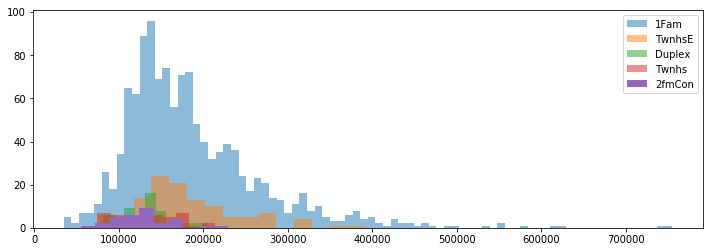

In [12]:
########### BldgType ############
# combined_df.BldgType.value_counts().plot(kind='bar')
# combined_df.BldgType.value_counts()


# BT_Unique = train_X2.BldgType.unique()
# BT_Uvals = pd.DataFrame()

# for i in BT_Unique:
#     curr_SP = train_X2.loc[train_X2.BldgType==i,'SalePrice']
#     curr_mean = np.mean(curr_SP)
#     curr_std = np.std(curr_SP)
#     BT_Uvals = BT_Uvals.append({'BldgType':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)
# BT_Uvals


rcParams['figure.figsize'] = 12, 4 #width x height in inches
fig, ax = plt.subplots()
ax.hist(train_X2.loc[train_X2.BldgType=='1Fam','SalePrice'],alpha=0.5,label='1Fam',bins=80)
ax.hist(train_X2.loc[train_X2.BldgType=='TwnhsE','SalePrice'],alpha=0.5,label='TwnhsE',bins=15)
ax.hist(train_X2.loc[train_X2.BldgType=='Duplex','SalePrice'],alpha=0.5,label='Duplex',bins=10)
ax.hist(train_X2.loc[train_X2.BldgType=='Twnhs','SalePrice'],alpha=0.5,label='Twnhs',bins=10)
ax.hist(train_X2.loc[train_X2.BldgType=='2fmCon','SalePrice'],alpha=1,label='2fmCon',bins=10)
leg = ax.legend()
combined_df.BldgType.value_counts()


# I decided not to combine these two categories in the end because these two are very distinctive and have different distributions.
# combined_df.loc[combined_df.BldgType == 'TwnhsE','BldgType'] = 'TwnhsAll'
# combined_df.loc[combined_df.BldgType == 'Twnhs','BldgType'] = 'TwnhsAll'

#Double check that it worked.
#combined_df.BldgType.unique()

1Story    1470
2Story     871
1.5Fin     314
SLvl       127
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: HouseStyle, dtype: int64

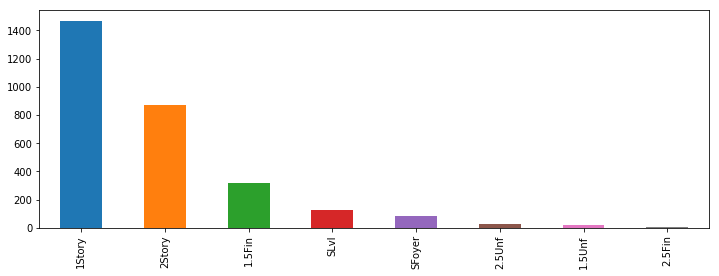

In [13]:
########### HouseStyle #############
combined_df.HouseStyle.value_counts().plot(kind='bar')
combined_df.HouseStyle.value_counts()


# HS_Unique = train_X2.HouseStyle.unique()
# HS_Uvals = pd.DataFrame()

# for i in HS_Unique:
#     curr_SP = train_X2.loc[train_X2.HouseStyle==i,'SalePrice']
#     curr_mean = np.mean(curr_SP)
#     curr_std = np.std(curr_SP)
#     HS_Uvals = HS_Uvals.append({'HouseStyle':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)
# HS_Uvals


# rcParams['figure.figsize'] = 12, 4 #width x height in inches
# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.HouseStyle=='1Story','SalePrice'],alpha=0.5,label='1Story',bins=30)
# ax.hist(train_X2.loc[train_X2.HouseStyle=='2Story','SalePrice'],alpha=0.5,label='2Story',bins=25)
# ax.hist(train_X2.loc[train_X2.HouseStyle=='1.5Fin','SalePrice'],alpha=0.5,label='1.5Fin',bins=10)
# ax.hist(train_X2.loc[train_X2.HouseStyle=='SLvl','SalePrice'],alpha=0.5,label='SLvl',bins=10)
# leg = ax.legend()


# rcParams['figure.figsize'] = 12, 4 #width x height in inches
# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.HouseStyle=='SFoyer','SalePrice'],alpha=0.5,label='SFoyer',bins=10)
# ax.hist(train_X2.loc[train_X2.HouseStyle=='2.5Unf','SalePrice'],alpha=0.5,label='2.5Unf',bins=10)
# ax.hist(train_X2.loc[train_X2.HouseStyle=='1.5Unf','SalePrice'],alpha=1,label='1.5Unf',bins=10)
# ax.hist(train_X2.loc[train_X2.HouseStyle=='2.5Fin','SalePrice'],alpha=0.5,label='2.5Fin',bins=10)
# leg = ax.legend()

In [14]:
######### OverallCond and OverallQual ##########
#We're going to combined these two values into a single column then throw them away.
OverallRating = combined_df.OverallQual + combined_df.OverallCond
combined_df['OverallRating'] = OverallRating
combined_df = combined_df.drop({'OverallQual','OverallCond'},axis=1)

#Double check that it worked.
#combined_df.columns

In [15]:
######### Exterior1st ###########
#combined_df.Exterior1st.value_counts().plot(kind='bar')
# combined_df.Exterior1st.value_counts()

# E1_Unique = train_X2.Exterior1st.unique()
# E1_Uvals = pd.DataFrame()

# for i in E1_Unique:
#     curr_SP = train_X2.loc[train_X2.Exterior1st==i,'SalePrice']
#     curr_mean = np.mean(curr_SP)
#     curr_std = np.std(curr_SP)
#     E1_Uvals = E1_Uvals.append({'Exterior1st':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)
    
# E1_Uvals


########## Exterior2nd ###########
# combined_df.Exterior2nd.value_counts().plot(kind='bar')
# combined_df.Exterior2nd.value_counts()


# E2_Unique = train_X2.Exterior2nd.unique()
# E2_Uvals = pd.DataFrame()

# for i in E2_Unique:
#     curr_SP = train_X2.loc[train_X2.Exterior2nd==i,'SalePrice']
#     curr_mean = np.mean(curr_SP)
#     curr_std = np.std(curr_SP)
#     E2_Uvals = E2_Uvals.append({'Exterior2nd':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)
    
# E2_Uvals

combined_df = combined_df.drop({'Exterior1st','Exterior2nd'},axis=1)

No    1904
Av     418
Gd     276
Mn     239
NA      79
Name: BsmtExposure, dtype: int64

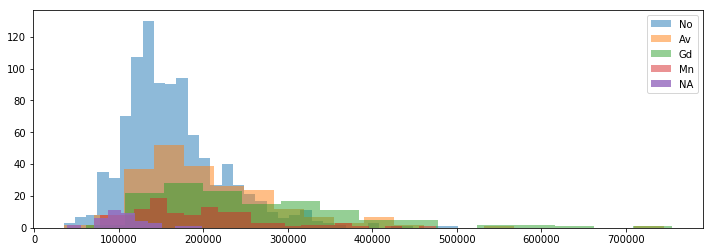

In [16]:
########## BsmtExposure ###########
#combined_df.BsmtExposure.value_counts().plot(kind='bar')
#combined_df.BsmtExposure.value_counts()


# BE_unique = combined_df.BsmtExposure.unique()
# BE_Uvals = pd.DataFrame()
# for i in BE_unique:
#     curr_SP = train_X2.loc[train_X2.BsmtExposure==i,'SalePrice']
#     curr_mean = np.mean(curr_SP)
#     curr_std = np.std(curr_SP)
#     BE_Uvals = BE_Uvals.append({'BsmtExposure':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)
# BE_Uvals


rcParams['figure.figsize'] = 12, 4 #width x height in inches
fig, ax = plt.subplots()
ax.hist(train_X2.loc[train_X2.BsmtExposure=='No','SalePrice'],alpha=0.5,label='No',bins=35)
ax.hist(train_X2.loc[train_X2.BsmtExposure=='Av','SalePrice'],alpha=0.5,label='Av',bins=20)
ax.hist(train_X2.loc[train_X2.BsmtExposure=='Gd','SalePrice'],alpha=0.5,label='Gd',bins=15)
ax.hist(train_X2.loc[train_X2.BsmtExposure=='Mn','SalePrice'],alpha=0.5,label='Mn',bins=20)
ax.hist(train_X2.loc[train_X2.BsmtExposure=='NA','SalePrice'],alpha=0.8,label='NA',bins=10)
leg = ax.legend()

combined_df.BsmtExposure.value_counts()

In [17]:
############ BsmtFinType1 ############
# combined_df.BsmtFinType1.value_counts().plot(kind='bar')
# combined_df.BsmtFinType1.value_counts()


B1_unique = combined_df.BsmtFinType1.unique()
B1_uvals = pd.DataFrame()

for i in B1_unique:
    curr_SP = train_X2.loc[train_X2.BsmtFinType1 == i,'SalePrice']
    curr_mean = np.mean(curr_SP)
    curr_std = np.std(curr_SP)
    B1_uvals = B1_uvals.append({'BsmtFinType1':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)
B1_uvals


# rcParams['figure.figsize'] = 12, 4 #width x height in inches
# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.BsmtFinType1=='Unf','SalePrice'],alpha=0.5,label='Unf',bins=20)
# ax.hist(train_X2.loc[train_X2.BsmtFinType1=='GLQ','SalePrice'],alpha=0.5,label='GLQ',bins=20)
# ax.hist(train_X2.loc[train_X2.BsmtFinType1=='ALQ','SalePrice'],alpha=0.5,label='ALQ',bins=15)
# ax.hist(train_X2.loc[train_X2.BsmtFinType1=='Rec','SalePrice'],alpha=0.5,label='Rec',bins=20)
# leg = ax.legend()
# combined_df.BsmtFinType1.value_counts()

# rcParams['figure.figsize'] = 12, 4 #width x height in inches
# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.BsmtFinType1=='BLQ','SalePrice'],alpha=0.5,label='BLQ',bins=20)
# ax.hist(train_X2.loc[train_X2.BsmtFinType1=='LwQ','SalePrice'],alpha=0.5,label='LwQ',bins=15)
# ax.hist(train_X2.loc[train_X2.BsmtFinType1=='NA','SalePrice'],alpha=0.7,label='Na',bins=10)
# leg = ax.legend()

,BsmtFinType1,MeanSalePrice,STDSalePrice
0,GLQ,235297.206235,93185.170518
1,ALQ,161573.068182,50705.642776
2,Unf,170626.981308,72653.980514
3,Rec,146889.248120,45019.910670
4,BLQ,149493.655405,47167.131626
5,NA,105652.891892,28880.326645
6,LwQ,151852.702703,50452.596759


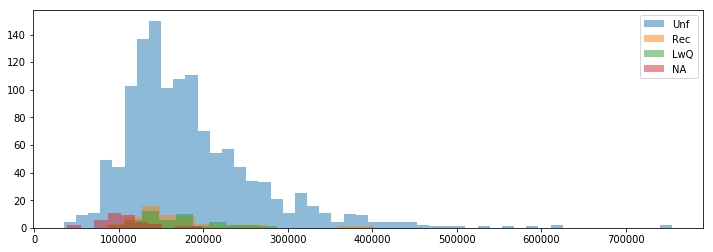

In [18]:
############ BsmtFinType2 ############
# combined_df.BsmtFinType2.value_counts().plot(kind='bar')
# combined_df.BsmtFinType2.value_counts()


# B2_unique = combined_df.BsmtFinType2.unique()
# B2_uvals = pd.DataFrame()
# for i in B2_unique:
#     curr_SP = train_X2.loc[train_X2.BsmtFinType2 == i,'SalePrice']
#     curr_mean = np.mean(curr_SP)
#     curr_std = np.std(curr_SP)
#     B2_uvals = B2_uvals.append({'BsmtFinType2':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)
# B2_uvals

#combined_df.BsmtFinType2.value_counts()

rcParams['figure.figsize'] = 12, 4 #width x height in inches
fig, ax = plt.subplots()
ax.hist(train_X2.loc[train_X2.BsmtFinType2=='Unf','SalePrice'],alpha=0.5,label='Unf',bins=50)
ax.hist(train_X2.loc[train_X2.BsmtFinType2=='Rec','SalePrice'],alpha=0.5,label='Rec',bins=15)
ax.hist(train_X2.loc[train_X2.BsmtFinType2=='LwQ','SalePrice'],alpha=0.5,label='LwQ',bins=10)
ax.hist(train_X2.loc[train_X2.BsmtFinType2=='NA','SalePrice'],alpha=0.5,label='NA',bins=10)
leg = ax.legend()


# rcParams['figure.figsize'] = 12, 4 #width x height in inches
# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.BsmtFinType2=='BLQ','SalePrice'],alpha=0.5,label='BLQ',bins=15)
# ax.hist(train_X2.loc[train_X2.BsmtFinType2=='ALQ','SalePrice'],alpha=0.5,label='ALQ',bins=15)
# ax.hist(train_X2.loc[train_X2.BsmtFinType2=='GLQ','SalePrice'],alpha=0.5,label='GLQ',bins=10)
# leg = ax.legend()

In [19]:
######### Electrical #########
#combined_df.Electrical.value_counts().plot(kind='bar')
combined_df.Electrical.value_counts()


# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.Electrical=='SBrkr','SalePrice'],alpha=0.5,label='SBrkr',bins=60)
# ax.hist(train_X2.loc[train_X2.Electrical=='FuseA','SalePrice'],alpha=0.5,label='FuseA',bins=15)
# ax.hist(train_X2.loc[train_X2.Electrical=='FuseF','SalePrice'],alpha=0.5,label='FuseF',bins=10)
# leg = ax.legend()
# combined_df.Electrical.value_counts()

# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.Electrical=='FuseP','SalePrice'],alpha=0.5,label='FuseP',bins=5)
# ax.hist(train_X2.loc[train_X2.Electrical=='Mix','SalePrice'],alpha=0.5,label='Mix',bins=1)
# leg = ax.legend()

#train_X2.loc[train_X2.Electrical=='Mix',:] #SalePrice = $67,000

combined_df = combined_df.drop('Electrical',axis=1)

In [20]:
########## Functional ##########
#combined_df.Functional.value_counts().plot(kind='bar')
combined_df.Functional.value_counts()


# F_unique = combined_df.Functional.unique()
# F_uvals = pd.DataFrame()
# for i in F_unique:
#     curr_SP = train_X2.loc[train_X2.Functional == i,'SalePrice']
#     curr_mean = np.mean(curr_SP)
#     curr_std = np.std(curr_SP)
#     F_uvals = F_uvals.append({'Functional':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)
# F_uvals

# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.Functional=='Typ','SalePrice'],alpha=0.5,label='Typ',bins=60)
# ax.hist(train_X2.loc[train_X2.Functional=='Min2','SalePrice'],alpha=0.5,label='Min2',bins=10)
# ax.hist(train_X2.loc[train_X2.Functional=='Min1','SalePrice'],alpha=0.5,label='Min1',bins=10)
# ax.hist(train_X2.loc[train_X2.Functional=='Mod','SalePrice'],alpha=0.7,label='Mod',bins=10)
# leg = ax.legend()

# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.Functional=='Maj1','SalePrice'],alpha=0.5,label='Maj1',bins=10)
# ax.hist(train_X2.loc[train_X2.Functional=='Maj2','SalePrice'],alpha=0.5,label='Maj2',bins=10)
# ax.hist(train_X2.loc[train_X2.Functional=='Sev','SalePrice'],alpha=1,label='Sev',bins=10) #$129,000
# leg = ax.legend()


combined_df = combined_df.drop('Functional',axis=1)

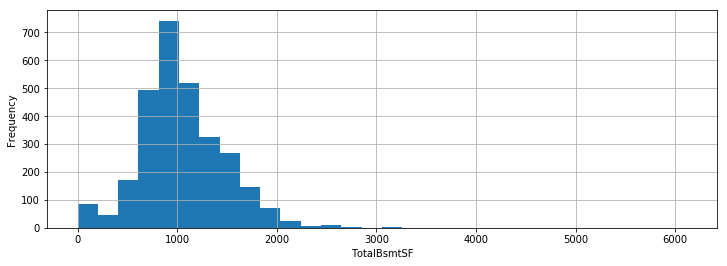

In [21]:
######## BsmtFullBath, BsmtHalfBath, FullBath, HalfBath ###########
#This equation is not true for all entries
#combined_df.BedroomAbvGr + combined_df.KitchenAbvGr == combined_df.TotRmsAbvGrd
#combined_df.loc[:,{'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd'}]

#Boxplot of the bathroom variables
#combined_df.loc[:,{'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'}].boxplot()
#combined_df.BsmtHalfBath.plot.box()

#HalfBath outliers
#train_X2.plot(x='HalfBath',y='SalePrice',kind='scatter',title='SalePrice vs HalfBath')

#BsmtHalfBath outliers
#combined_df.loc[combined_df.BsmtHalfBath==2,:]
#train_X2.loc[combined_df.BsmtHalfBath==2,:]
#train_X2.plot(y='SalePrice',x='BsmtHalfBath',kind='scatter',title='SalePrice vs BsmtHalfBath')
#combined_df.loc[combined_df.BsmtHalfBath==1,:]

#FullBath outliers 
#combined_df.loc[combined_df.FullBath==4,:]
#train_X2.loc[train_X2.FullBath==4,:]
#train_X2.plot(x='FullBath',y='SalePrice',kind='scatter',title='SalePrice vs FullBath')


#BsmtFullBath outliers
#combined_df.loc[combined_df.BsmtFullBath==3,:]
#train_X2.loc[train_X2.BsmtFullBath==3,:]
#train_X2.plot(x='BsmtFullBath',y='SalePrice',kind='scatter',title='SalePrice vs BsmtFullBath')


#Check TotalBsmtSF histogram
combined_df.TotalBsmtSF.hist(bins=30)
plt.ylabel('Frequency')
plt.xlabel('TotalBsmtSF')
#train_X2.plot(x='TotalBsmtSF',y='SalePrice',kind='scatter',title='SalePrice vs TotalBsmtSF')
#train_X2.loc[train_X2.TotalBsmtSF>6000,:]
#combined_df.loc[combined_df.BsmtFullBath == 3,:]

# Run this after the analysis.
BsmtTotBath = combined_df.BsmtFullBath + (0.5)*combined_df.BsmtHalfBath
combined_df['BsmtTotBath'] = BsmtTotBath
TotBathAbvGrd = combined_df.FullBath + (0.5)*combined_df.HalfBath
combined_df['TotBathAbvGrd'] = TotBathAbvGrd
combined_df = combined_df.drop({'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'},axis=1)

6     844
7     646
5     583
8     347
4     196
9     143
10     80
11     32
3      25
12     16
15      1
13      1
14      1
2       1
Name: TotRmsAbvGrd, dtype: int64

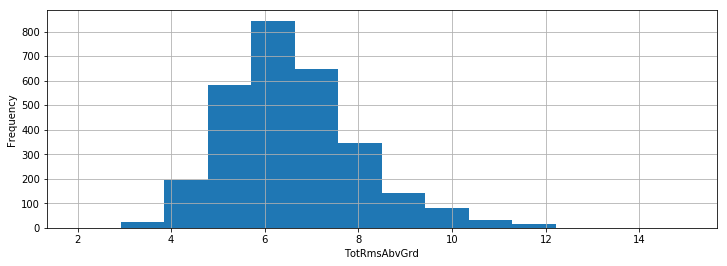

In [22]:
############ KitchenAbvGr ############
############ DOUBLE CHECK THIS AGAIN TO SEE IF IT IS POSSIBLE THAT THE ######
############ KITCHENS CAN BE IN A BASEMENT BASED ON THE HOUSETYPE ###########

#combined_df.KitchenAbvGr.hist()
#combined_df.KitchenAbvGr.value_counts()
#combined_df.KitchenAbvGr.plot.box()
#train_X2.plot(x='KitchenAbvGr',y='SalePrice',kind='scatter',title='SalePrice vs KitchenAbvGr')
train_X2.loc[train_X2.KitchenAbvGr==3,:]
#train_X2.loc[train_X2.KitchenAbvGr==2,:].plot(x='GrLivArea',y='SalePrice',kind='scatter',title='SalePrice vs GrLivArea (KitchenAbvGr = 2)')
#train_X2.loc[train_X2.KitchenAbvGr==0,:]
#### We do not need to change these values to an NA, because it is actually possible 
#### that these Kitchens are below grade and are in the basement
#combined_df.loc[combined_df.KitchenAbvGr==0,'KitchenQual'] = 'NA'
#combined_df.loc[combined_df.KitchenAbvGr==0,:]


############ BedroomAbvGr ############
# combined_df.BedroomAbvGr.hist(bins=8)
# combined_df.BedroomAbvGr.value_counts()
# combined_df.BedroomAbvGr.plot.box()
# train_X2.plot(x='BedroomAbvGr',y='SalePrice',kind='scatter',title='SalePrice vs BedroomAbvGr')
#train_X2.loc[train_X2.BedroomAbvGr==0,:]
#combined_df.loc[combined_df.BedroomAbvGr==0,:]

#train_X2.loc[train_X2.BedroomAbvGr==5,:].shape
#combined_df.loc[combined_df.BedroomAbvGr==5,:]
#combined_df.loc[combined_df.BedroomAbvGr>=5,:].plot(x='BedroomAbvGr',y='TotRmsAbvGrd',kind='scatter',title='Total Rooms Above Grade vs  Bedroom Above Grade')

# combined_df.loc[combined_df.BedroomAbvGr==8,:]
# train_X2.loc[train_X2.BedroomAbvGr==8,:]


######### TotRmsAbvGrd ###########
combined_df.TotRmsAbvGrd.hist(bins=14)
plt.ylabel('Frequency')
plt.xlabel('TotRmsAbvGrd')
combined_df.TotRmsAbvGrd.value_counts()

#combined_df.TotRmsAbvGrd.plot.box()

#Only one entry in train_X2
#train_X2.loc[train_X2.TotRmsAbvGrd>13,:].plot(x='TotRmsAbvGrd',y='SalePrice',kind='scatter',title='SalePrice vs TotRmsAbvGrd')
#train_X2.loc[train_X2.TotRmsAbvGrd>=13,:]

# combined_df.loc[combined_df.TotRmsAbvGrd>=13,:]
# combined_df.loc[combined_df.TotRmsAbvGrd>=13,:].plot(x='TotRmsAbvGrd',y='GrLivArea',title='GrLivArea vs TotRmsAbvGrd',kind='scatter')

In [23]:
########## PavedDrive ##########
#combined_df.PavedDrive.value_counts().plot(kind='bar')
#combined_df.PavedDrive.value_counts()


# PD_unique = combined_df.PavedDrive.unique()
# PD_uvals = pd.DataFrame()
# for i in PD_unique:
#     curr_SP = train_X2.loc[train_X2.PavedDrive == i,'SalePrice']
#     curr_mean = np.mean(curr_SP)
#     curr_std = np.std(curr_SP)
#     PD_uvals = PD_uvals.append({'PavedDrive':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)
# PD_uvals

# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.PavedDrive=='Y','SalePrice'],alpha=0.5,label='Y',bins=60)
# ax.hist(train_X2.loc[train_X2.PavedDrive=='N','SalePrice'],alpha=0.5,label='N',bins=10)
# ax.hist(train_X2.loc[train_X2.PavedDrive=='P','SalePrice'],alpha=0.5,label='P',bins=10)
# leg = ax.legend()
# combined_df.PavedDrive.value_counts()



combined_df = combined_df.drop('PavedDrive',axis=1)


Text(0.5,0,'combo_porch')

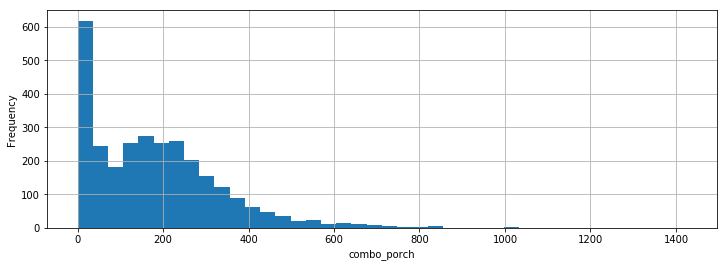

In [24]:
########## WoodDeckSF ##########
# combined_df.WoodDeckSF.hist(bins=20)
# plt.ylabel('Frequency')
# plt.xlabel('WoodDeckSF')
#combined_df.WoodDeckSF.value_counts()
#train_X2.plot(x='WoodDeckSF',y='SalePrice',kind='scatter',title='SalePrice vs WoodDeckSF')

########## OpenPorchSF #########
# combined_df.OpenPorchSF.hist(bins=20)
# plt.ylabel('Frequency')
# plt.xlabel('OpenPorchSF')
#combined_df.OpenPorchSF.value_counts()
#train_X2.plot(x='OpenPorchSF',y='SalePrice',kind='scatter',title='SalePrice vs OpenPorchSF')

########## EnclosedPorch #########
# combined_df.EnclosedPorch.hist(bins=20)
# plt.ylabel('Frequency')
# plt.xlabel('EnclosedPorch')
#combined_df.EnclosedPorch.value_counts()
#train_X2.plot(x='EnclosedPorch',y='SalePrice',kind='scatter',title='SalePrice vs EnclosedPorch')

########## 3SsnPorch #########
# combined_df.loc[:,'3SsnPorch'].hist(bins=20)
# plt.ylabel('Frequency')
# plt.xlabel('3SsnPorch')
#combined_df.loc[:,'3SsnPorch'].value_counts()
#train_X2.plot(x='3SsnPorch',y='SalePrice',kind='scatter',title='SalePrice vs 3SsnPorch')

########## ScreenPorch #########
# combined_df.ScreenPorch.hist(bins=20)
# plt.ylabel('Frequency')
# plt.xlabel('ScreenPorch')
#combined_df.ScreenPorch.value_counts()
#train_X2.plot(x='ScreenPorch',y='SalePrice',kind='scatter',title='SalePrice vs ScreenPorch')



#These will find all entries that have multiple different porches.
porches = combined_df.loc[:,{'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'}]
rows = porches.shape[0]
multiple_porches = []
no_porches = []
for i in range(rows):
    curr_row = porches.loc[i,:]
    countzeroes = np.count_nonzero(curr_row)
    if countzeroes > 1:
        multiple_porches.append(i)
    if countzeroes == 0:
        no_porches.append(i)
#porches.loc[multiple_porches,:]
#porches.loc[no_porches,:].shape



#Experimenting with porches and SalesPrice
porches_SP = train_X2.loc[:,{'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','SalePrice'}]
porch_tX2 = train_X2.loc[:,{'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'}]
combo_porch = np.sum(porch_tX2,axis=1)
porches_SP['combo_porch'] = combo_porch
#porches_SP.corr().style.background_gradient(cmap='coolwarm')
#porches_SP.plot(x='combo_porch',y='SalePrice',kind='scatter',title='SalePrice vs combo_porch')



combo_porch2 = np.sum(porches,axis=1)
combined_df['combo_porch'] = combo_porch2
combined_df = combined_df.drop({'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'},axis=1)
combined_df.combo_porch.hist(bins=40)
plt.ylabel('Frequency')
plt.xlabel('combo_porch')




In [25]:
########### PoolArea ###########
# combined_df.loc[combined_df.PoolArea > 0,'PoolArea'].hist() #this hist doesn't offer any good info
# plt.ylabel('Frequency')
# plt.xlabel('PoolArea')
#combined_df.PoolArea.value_counts()

#combined_df.PoolArea.plot.box()
#combined_df.loc[combined_df.PoolArea >0,:]
#train_X2.loc[train_X2.PoolArea >0,:].plot(x='PoolArea',y='SalePrice',kind='scatter',title='SalePrice vs PoolArea')

train_X2.loc[train_X2.PoolArea>0,{'PoolArea','SalePrice'}].corr()


combined_df = combined_df.drop('PoolArea',axis=1)

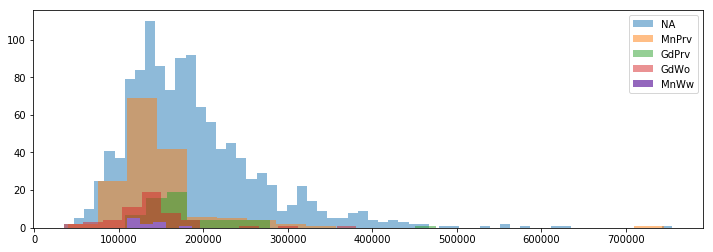

In [26]:
########### Fence ############
# combined_df.Fence.value_counts().plot(kind='bar')
# combined_df.Fence.value_counts()

# F_unique = combined_df.Fence.unique()
# F_uvals = pd.DataFrame()

# for i in F_unique:
#     curr_SP = train_X2.loc[train_X2.Fence==i,'SalePrice']
#     curr_mean = np.mean(curr_SP)
#     curr_std = np.std(curr_SP)
#     F_uvals = F_uvals.append({'Fence':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)
# F_uvals



fig, ax = plt.subplots()
ax.hist(train_X2.loc[train_X2.Fence=='NA','SalePrice'],alpha=0.5,label='NA',bins=60)
ax.hist(train_X2.loc[train_X2.Fence=='MnPrv','SalePrice'],alpha=0.5,label='MnPrv',bins=20)
ax.hist(train_X2.loc[train_X2.Fence=='GdPrv','SalePrice'],alpha=0.5,label='GdPrv',bins=15)
ax.hist(train_X2.loc[train_X2.Fence=='GdWo','SalePrice'],alpha=0.5,label='GdWo',bins=15)
ax.hist(train_X2.loc[train_X2.Fence=='MnWw','SalePrice'],alpha=1,label='MnWw',bins=5)
leg = ax.legend()

In [27]:
########## MiscFeature ############
# combined_df.MiscFeature.value_counts().plot(kind='bar')
# combined_df.MiscFeature.value_counts()

# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.MiscFeature=='NA','SalePrice'],alpha=0.5,label='NA',bins=60)
# ax.hist(train_X2.loc[train_X2.MiscFeature=='Shed','SalePrice'],alpha=0.5,label='Shed',bins=10)
# ax.hist(train_X2.loc[train_X2.MiscFeature=='Gar2','SalePrice'],alpha=0.5,label='Gar2',bins=5)
# ax.hist(train_X2.loc[train_X2.MiscFeature=='Othr','SalePrice'],alpha=0.5,label='Othr',bins=5)
# ax.hist(train_X2.loc[train_X2.MiscFeature=='TenC','SalePrice'],alpha=1,label='TenC',bins=1)
# leg = ax.legend()
#train_X2.loc[train_X2.MiscFeature == 'TenC',:]


########## MiscVal ###############
# combined_df.loc[combined_df.MiscVal>0,'MiscVal'].hist(bins=100)
# plt.ylabel('Frequency')
# plt.xlabel('MiscVal')
#combined_df.MiscVal.value_counts()
#combined_df.loc[combined_df.MiscFeature != 'NA',{'Id','MiscFeature','MiscVal'}]
#train_X2.plot(x='MiscVal',y='SalePrice',kind='scatter',title='SalePrice vs MiscVal')

# Misc_unique = combined_df.MiscFeature.unique()
# Misc_uvals = pd.DataFrame()
# for i in Misc_unique:
#     curr_SP = train_X2.loc[train_X2.MiscFeature==i,'MiscVal']
#     if i == 'Shed':
#         curr_SP = train_X2.loc[train_X2.MiscFeature==i,:]
#         curr_SP = curr_SP.loc[curr_SP.MiscVal>0,'MiscVal']
#     if i == 'Othr':
#         curr_SP = train_X2.loc[train_X2.MiscFeature==i,:]
#         curr_SP = curr_SP.loc[curr_SP.MiscVal>0,'MiscVal']
#     curr_mean = np.mean(curr_SP)
#     curr_median = np.median(curr_SP)
#     curr_std = np.std(curr_SP)
#     Misc_uvals = Misc_uvals.append({'MiscFeature':i,'MeanValue':curr_mean,'STDValue':curr_std},ignore_index=True)
# Misc_uvals

#All the MiscFeatures with MiscVal=0
#combined_df.loc[{872,1198,2428},:]
combined_df.loc[872,'MiscVal'] = 3500.00
combined_df.loc[1198,'MiscVal'] = 712.375
combined_df.loc[2428,'MiscVal'] = 712.375

train_X2.loc[train_X2.MiscVal>0,{'MiscVal','SalePrice'}].corr()

#Drop MiscFeature and MiscVal
combined_df = combined_df.drop('MiscFeature',axis=1)
combined_df = combined_df.drop('MiscVal',axis=1)

In [28]:
########### SaleType ###########
# combined_df.SaleType.value_counts().plot(kind='bar')
# combined_df.SaleType.value_counts()


#fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.SaleType=='WD','SalePrice'],alpha=0.5,label='WD',bins=60)
# ax.hist(train_X2.loc[train_X2.SaleType=='New','SalePrice'],alpha=0.5,label='New',bins=20)
# ax.hist(train_X2.loc[train_X2.SaleType=='COD','SalePrice'],alpha=0.5,label='COD',bins=15)
# ax.hist(train_X2.loc[train_X2.SaleType=='ConLD','SalePrice'],alpha=0.5,label='ConLD',bins=15)
# ax.hist(train_X2.loc[train_X2.SaleType=='CWD','SalePrice'],alpha=1,label='CWD',bins=10)
# ax.hist(train_X2.loc[train_X2.SaleType=='ConLI','SalePrice'],alpha=0.5,label='ConLI',bins=10)
# ax.hist(train_X2.loc[train_X2.SaleType=='ConLw','SalePrice'],alpha=0.5,label='ConLw',bins=5)
# ax.hist(train_X2.loc[train_X2.SaleType=='Oth','SalePrice'],alpha=0.5,label='Oth',bins=5)
# ax.hist(train_X2.loc[train_X2.SaleType=='Con','SalePrice'],alpha=0.5,label='Con',bins=5)
# leg = ax.legend()
# combined_df.SaleType.value_counts()



combined_df.loc[combined_df.SaleType=='ConLD','SaleType'] = 'Contract'
combined_df.loc[combined_df.SaleType=='ConLI','SaleType'] = 'Contract'
combined_df.loc[combined_df.SaleType=='ConLw','SaleType'] = 'Contract'
combined_df.loc[combined_df.SaleType=='Con','SaleType'] = 'Contract'


In [29]:
########### SaleCondition ###########
# combined_df.SaleCondition.value_counts().plot(kind='bar')
combined_df.SaleCondition.value_counts()



# fig, ax = plt.subplots()
# ax.hist(train_X2.loc[train_X2.SaleCondition=='Normal','SalePrice'],alpha=0.5,label='Normal',bins=60)
# ax.hist(train_X2.loc[train_X2.SaleCondition=='Partial','SalePrice'],alpha=0.5,label='Partial',bins=20)
# ax.hist(train_X2.loc[train_X2.SaleCondition=='Abnorml','SalePrice'],alpha=0.5,label='Abnorml',bins=15)
# ax.hist(train_X2.loc[train_X2.SaleCondition=='Family','SalePrice'],alpha=0.5,label='Family',bins=15)
# ax.hist(train_X2.loc[train_X2.SaleCondition=='Alloca','SalePrice'],alpha=0.5,label='Alloca',bins=15)
# ax.hist(train_X2.loc[train_X2.SaleCondition=='AdjLand','SalePrice'],alpha=0.5,label='AdjLand',bins=5)
# leg = ax.legend()
# combined_df.SaleCondition.value_counts()

combined_df.loc[combined_df.SaleCondition == 'AdjLand',:]




,Id,MSZoning,LotFrontage,LotArea,LotConfig,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,HeatingQC,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,Fence,MoSold,YrSold,SaleType,SaleCondition,LotShapeBinary,OverallRating,BsmtTotBath,TotBathAbvGrd,combo_porch
39,40,RL,65.0,6040,Inside,Duplex,1Story,1955,1955,Gable,None,0.0,TA,TA,PConc,NA,NA,NA,NA,NA,0.0,TA,1152,2,2,Fa,6,0,NA,NA,0.0,NA,0.0,0.0,NA,NA,NA,6,2008,WD,AdjLand,1.0,9,0.0,2.0,0
385,387,RL,58.0,8410,FR,1Fam,1.5Fin,1910,1996,Gambrel,None,0.0,TA,Fa,PConc,TA,TA,No,Unf,Unf,658.0,TA,1184,5,1,TA,8,0,NA,NA,0.0,NA,0.0,0.0,NA,NA,NA,5,2006,WD,AdjLand,1.0,8,0.0,1.0,151
417,419,RL,60.0,8160,Inside,1Fam,1.5Fin,1940,1950,Gable,None,0.0,TA,TA,BrkTil,TA,TA,No,ALQ,Unf,756.0,Fa,1134,3,1,TA,7,0,NA,Detchd,1940.0,Unf,1.0,240.0,TA,TA,NA,4,2007,WD,AdjLand,1.0,11,1.0,1.5,0
952,955,RL,35.0,9400,CulDSac,Duplex,SFoyer,1975,1975,Flat,BrkFace,250.0,TA,TA,CBlock,Gd,Gd,Gd,GLQ,Unf,945.0,TA,980,4,0,TA,4,0,NA,NA,0.0,NA,0.0,0.0,NA,NA,NA,10,2006,WD,AdjLand,0.0,11,1.0,2.0,0
2186,2190,RL,65.0,6012,Corner,Duplex,1Story,1955,1955,Gable,None,0.0,TA,Fa,PConc,NA,NA,NA,NA,NA,0.0,TA,1152,2,2,TA,6,0,NA,NA,0.0,NA,0.0,0.0,NA,NA,NA,6,2008,WD,AdjLand,1.0,9,0.0,2.0,0
2464,2468,RM,40.0,5680,Inside,1Fam,1.5Fin,1901,1950,Gable,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,Unf,592.0,TA,1173,3,1,TA,7,0,NA,Detchd,1920.0,Unf,1.0,240.0,TA,Fa,MnPrv,9,2007,WD,AdjLand,1.0,9,0.0,2.0,102
2465,2469,RM,40.0,5680,Inside,1Fam,1.5Fin,1901,1950,Gable,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,Unf,969.0,TA,1214,2,1,TA,6,0,NA,Detchd,1920.0,Unf,1.0,216.0,TA,TA,MnPrv,9,2007,WD,AdjLand,1.0,8,0.0,1.0,77
2554,2558,RL,60.0,10890,Inside,Duplex,2Story,1923,1950,Hip,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,Unf,1296.0,Fa,2592,6,2,TA,12,0,NA,NA,0.0,NA,0.0,0.0,NA,NA,NA,1,2007,WD,AdjLand,1.0,11,2.0,2.0,982
2856,2860,RL,38.0,7840,CulDSac,Duplex,SFoyer,1975,1975,Flat,BrkFace,355.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,Unf,976.0,TA,1012,4,0,TA,4,0,NA,NA,0.0,NA,0.0,0.0,NA,NA,NA,10,2006,WD,AdjLand,0.0,11,1.0,2.0,0
2864,2868,RL,72.0,7822,Corner,1Fam,1.5Fin,1915,1950,Gable,None,0.0,TA,Fa,BrkTil,Fa,Fa,No,Unf,Unf,832.0,TA,1338,3,1,TA,7,0,NA,Detchd,1974.0,Unf,2.0,528.0,TA,TA,GdPrv,5,2006,WD,AdjLand,1.0,9,0.0,2.0,208


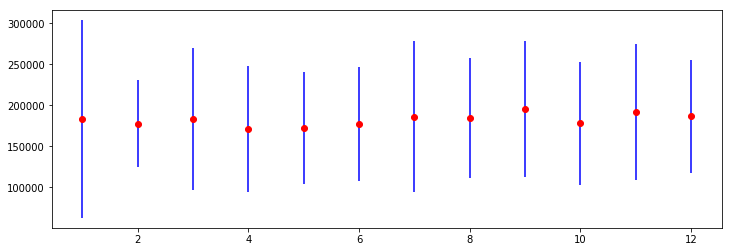

In [30]:
############ MoSold #############
# combined_df.MoSold.hist()
# plt.ylabel('Frequency')
# plt.xlabel('MoSold')
#train_X2.plot(x='MoSold',y='SalePrice',kind='scatter',title='SalePrice vs MoSold')

MoSoldAvg = pd.DataFrame()
MoSoldUnique = train_X2.MoSold.unique()

for i in MoSoldUnique:
    curr_SP = train_X2.loc[train_X2.MoSold == i,'SalePrice']
    curr_mean = np.mean(curr_SP)
    curr_std = np.std(curr_SP)
    MoSoldAvg = MoSoldAvg.append({'MoSold':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)

    
plt.errorbar(MoSoldAvg.MoSold,MoSoldAvg.MeanSalePrice,MoSoldAvg.STDSalePrice,fmt='r+',linestyle='None',marker='o',ecolor='b')

train_X2.loc[:,{'MoSold','SalePrice'}].corr()
combined_df = combined_df.drop('MoSold',axis=1)


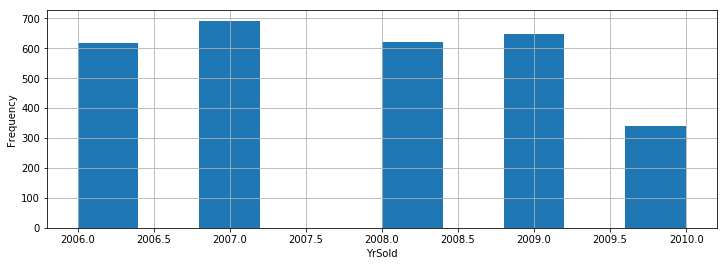

In [31]:
############ YrSold #############
combined_df.YrSold.hist()
plt.ylabel('Frequency')
plt.xlabel('YrSold')
#combined_df.YrSold.value_counts()

# YrSoldAvg = pd.DataFrame()
# YrSoldUnique = train_X2.YrSold.unique()

# for i in YrSoldUnique:
#     curr_SP = train_X2.loc[train_X2.YrSold == i,'SalePrice']
#     curr_mean = np.mean(curr_SP)
#     curr_std = np.std(curr_SP)
#     YrSoldAvg = YrSoldAvg.append({'YrSold':i,'MeanSalePrice':curr_mean,'STDSalePrice':curr_std},ignore_index=True)

    
# plt.errorbar(YrSoldAvg.YrSold,YrSoldAvg.MeanSalePrice,YrSoldAvg.STDSalePrice,fmt='r+',linestyle='None',marker='o',ecolor='b')

# train_X2.plot(x='YrSold',y='SalePrice',kind='scatter',title='SalePrice vs YrSold')
# train_X2.loc[:,{'YrSold','SalePrice'}].corr()
combined_df = combined_df.drop('YrSold',axis=1)

In [32]:
#The columns that remain after the feature engineering
np.sum(combined_df.isnull())

Id                0
MSZoning          0
LotFrontage       0
LotArea           0
LotConfig         0
BldgType          0
HouseStyle        0
YearBuilt         0
YearRemodAdd      0
RoofStyle         0
MasVnrType        0
MasVnrArea        0
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual          0
BsmtCond          0
BsmtExposure      0
BsmtFinType1      0
BsmtFinType2      0
TotalBsmtSF       0
HeatingQC         0
GrLivArea         0
BedroomAbvGr      0
KitchenAbvGr      0
KitchenQual       0
TotRmsAbvGrd      0
Fireplaces        0
FireplaceQu       0
GarageType        0
GarageYrBlt       0
GarageFinish      0
GarageCars        0
GarageArea        0
GarageQual        0
GarageCond        0
Fence             0
SaleType          0
SaleCondition     0
LotShapeBinary    0
OverallRating     0
BsmtTotBath       0
TotBathAbvGrd     0
combo_porch       0
dtype: int64

In [33]:
#Convert all ordinal and categorical variables to numerical variables
#Convert Ordinal variables into a numerical scale.
ordinal_cols_mapping = [{"col":"ExterQual",
                            "mapping":{'Ex':5,
                                        'Gd':4,
                                        'TA':3,
                                        'Fa':2,
                                        'Po':1}},
                         {"col":"ExterCond",
                            "mapping":{'Ex':5,
                                        'Gd':4,
                                        'TA':3,
                                        'Fa':2,
                                        'Po':1}},
                         {"col":"BsmtQual",
                            "mapping":{'Ex':5,
                                        'Gd':4,
                                        'TA':3,
                                        'Fa':2,
                                        'Po':1,
                                        'NA':0}},
                         {"col":"BsmtCond",
                             "mapping":{'Ex':5,
                                        'Gd':4,
                                        'TA':3,
                                        'Fa':2,
                                        'Po':1,
                                        'NA':0}},
                         {"col":"BsmtExposure",
                             "mapping":{'Gd':4,
                                        'Av':3,
                                        'Mn':2,
                                        'No':1,
                                        'NA':0}},
                         {"col":"BsmtFinType1",
                             "mapping":{'GLQ':6,
                                        'ALQ':5,
                                        'BLQ':4,
                                        'Rec':3,
                                        'LwQ':2,
                                        'Unf':1,
                                        'NA':0}},
                         {"col":"BsmtFinType2",
                             "mapping":{'GLQ':6,
                                        'ALQ':5,
                                        'BLQ':4,
                                        'Rec':3,
                                        'LwQ':2,
                                        'Unf':1,
                                        'NA':0}},
                         {"col":"HeatingQC",
                             "mapping":{'Ex':5,
                                        'Gd':4,
                                        'TA':3,
                                        'Fa':2,
                                        'Po':1}},
                         {"col":"KitchenQual",
                             "mapping":{'Ex':5,
                                        'Gd':4,
                                        'TA':3,
                                        'Fa':2,
                                        'Po':1}},
                         {"col":"FireplaceQu",
                             "mapping":{'Ex':5,
                                        'Gd':4,
                                        'TA':3,
                                        'Fa':2,
                                        'Po':1,
                                        'NA':0}},
                         {"col":"GarageFinish",
                             "mapping":{'Fin':3,
                                        'RFn':2,
                                        'Unf':1,
                                        'NA':0}},
                         {"col":"GarageQual",
                             "mapping":{'Ex':5,
                                        'Gd':4,
                                        'TA':3,
                                        'Fa':2,
                                        'Po':1,
                                        'NA':0}},
                         {"col":"GarageCond",
                             "mapping":{'Ex':5,
                                        'Gd':4,
                                        'TA':3,
                                        'Fa':2,
                                        'Po':1,
                                        'NA':0}}
                    ]
                         
ce_ord = ce.OrdinalEncoder(mapping = ordinal_cols_mapping,return_df = True)
combined_df = ce_ord.fit_transform(combined_df)

#Categorical variables being converted into one hot variables.
ce_one_hot = ce.OneHotEncoder(cols = ['MSZoning','LotConfig','BldgType','HouseStyle','RoofStyle',
                                      'MasVnrType','Foundation','GarageType','Fence','SaleType',
                                      'SaleCondition'])
combined_df = ce_one_hot.fit_transform(combined_df)

#ExterQual, ExterCond
ExterRating = combined_df.ExterQual + combined_df.ExterCond
combined_df['ExterRating'] = ExterRating
combined_df = combined_df.drop({'ExterQual','ExterCond'},axis=1)

#BsmtQual, BsmtCond
BsmtRating = combined_df.BsmtQual + combined_df.BsmtCond
combined_df['BsmtRating'] = BsmtRating
combined_df = combined_df.drop({'BsmtQual','BsmtCond'},axis=1)

#GarageQual, GarageCond
GarageRating = combined_df.GarageQual + combined_df.GarageCond
combined_df['GarageRating'] = GarageRating
combined_df = combined_df.drop({'GarageQual','GarageCond'},axis=1)



In [34]:
#Reorganize all the columns into a way that is similar to the original way the columns are organized
# np.sum(combined_df.isnull())
# combined_df.shape

columns_df = combined_df.columns.tolist()

columns_df = ['Id',
 'MSZoning_1',
 'MSZoning_2',
 'MSZoning_3',
 'MSZoning_4',
 'MSZoning_5',
 'LotFrontage',
 'LotArea',
 'LotShapeBinary',
 'LotConfig_1',
 'LotConfig_2',
 'LotConfig_3',
 'LotConfig_4',
 'BldgType_1',
 'BldgType_2',
 'BldgType_3',
 'BldgType_4',
 'BldgType_5',
 'HouseStyle_1',
 'HouseStyle_2',
 'HouseStyle_3',
 'HouseStyle_4',
 'HouseStyle_5',
 'HouseStyle_6',
 'HouseStyle_7',
 'HouseStyle_8',
 'OverallRating',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle_1',
 'RoofStyle_2',
 'RoofStyle_3',
 'RoofStyle_4',
 'RoofStyle_5',
 'RoofStyle_6',
 'MasVnrType_1',
 'MasVnrType_2',
 'MasVnrType_3',
 'MasVnrType_4',
 'MasVnrArea',
 'ExterRating',
 'Foundation_1',
 'Foundation_2',
 'Foundation_3',
 'Foundation_4',
 'Foundation_5',
 'Foundation_6',
 'BsmtRating',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'TotalBsmtSF',
 'HeatingQC',
 'GrLivArea',
 'BsmtTotBath',
 'TotBathAbvGrd',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'FireplaceQu',
 'GarageType_1',
 'GarageType_2',
 'GarageType_3',
 'GarageType_4',
 'GarageType_5',
 'GarageType_6',
 'GarageType_7',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageRating',
 'combo_porch',
 'Fence_1',
 'Fence_2',
 'Fence_3',
 'Fence_4',
 'Fence_5',
 'SaleType_1',
 'SaleType_2',
 'SaleType_3',
 'SaleType_4',
 'SaleType_5',
 'SaleType_6',
 'SaleCondition_1',
 'SaleCondition_2',
 'SaleCondition_3',
 'SaleCondition_4',
 'SaleCondition_5',
 'SaleCondition_6']

combined_df = combined_df[columns_df]


#To double check it is in the correct order.
#list(combined_df.columns)

In [35]:
############CORRELATIONS##########
#!!!! RUN AT THE END OF THIS SCRIPT, AFTER YOU FEATURE ENGINEER AND REMOVE APPROPRIATE COLUMNS !!!!#

#cwd = os.getcwd()
save_directory = '/Users/armenta/Desktop/Data Science/Kaggle/Getting Started Projects/Housing Data'
corr_vars = combined_df.corr()
output1 = corr_vars.style.background_gradient(cmap='coolwarm')
output1.to_excel(save_directory + '/correlations (combined_df, DP2, 10172019).xlsx',engine='openpyxl')
# file = open('correlations (combined_df) 10152019.pdf','w+')
# file.write(output1)
# file.close()

#Looking at SalePrice with correlations
train_X3 = combined_df.loc[combined_df.Id <= train_IDs[len(train_IDs)-1],:]
train_X3 = pd.concat([train_X3,train_y],axis=1)
corr_vars3 = train_X3.corr()
output2 = corr_vars3.style.background_gradient(cmap='coolwarm')
output2.to_excel(save_directory + '/correlations (train_X3, DP2, 10172019).xlsx',engine='openpyxl')
# file = open('correlations (train_X3) 10152019.pdf','w+')
# file.write(output2)
# file.close()

In [36]:
#Split the data back into the respective training and test sets
train_X2 = combined_df.loc[combined_df.Id <= train_IDs[len(train_IDs)-1],:]
train_X2 = train_X2.loc[:,train_X2.columns != 'Id']
train_X2 = train_X2.reset_index(drop = True)

test_X2 = combined_df.loc[combined_df.Id >= test_IDs[0],:]
test_X2 = test_X2.loc[:,test_X2.columns != 'Id']
test_X2 = test_X2.reset_index(drop = True)

train_y2 = train_y

#From the first pipeline
# train_X1 = combined_df1.loc[combined_df1.Id <= train_IDs[len(train_IDs)-1],:]
# train_X1 = train_X1.loc[:,train_X1.columns != 'Id']
# train_X1 = train_X1.reset_index(drop = True)

# test_X1 = combined_df1.loc[combined_df1.Id >= test_IDs[0],:]
# test_X1 = test_X1.loc[:,test_X1.columns != 'Id']
# test_X1 = test_X1.reset_index(drop = True)

# train_y1 = train_y


#Save the appropriate variables with the pickle package.
pickle_list2 = [train_X2,train_y2,test_X2,test_IDs]
f = open('DataPipeline2_pt2.pckl','wb')
pickle.dump(pickle_list2,f)
f.close()

In [49]:
#######CODE NOT BEING USED CURRENTLY 

#######LOTSHAPE########
# #Reg distribution 
# train_X2.loc[train_X2.LotShape=='Reg','SalePrice'].plot.hist(bins=40,alpha=0.5,label='Reg')
# #py.suptitle('SalePrice for LotShape = Reg')
# #IR1 distribution
# train_X2.loc[train_X2.LotShape=='IR1','SalePrice'].plot.hist(bins=40,alpha=0.5,label='IR1')
# #py.suptitle('SalePrice for LotShape = IR1')
# #IR2 distribution 
# train_X2.loc[train_X2.LotShape=='IR2','SalePrice'].plot.hist(bins=40,alpha=0.7,label='IR2')
# #IR3 distribution 
# train_X2.loc[train_X2.LotShape=='IR3','SalePrice'].plot.hist(bins=40,alpha=1,label='IR3')

##########SALEPRICE#############
# #Lets look at the distribution of SalePrice
# train_y.hist(bins=50)
# train_X2.boxplot(column='SalePrice')
# third_quantile = train_X2.loc[:,'SalePrice'].quantile(0.75)
# third_quantile_data = train_X2.loc[train_X2.SalePrice > third_quantile,:]
# third_quantile_data